# Анализ поведения пользователей Stepik'a и способы влиять на него

# Лирическое вступление

Пожалуй, одна из наиболее актуальных проблем образовательных онлайн-курсов - малый процент пользователей, которые полностью осваивают учебные программы.
Напрашиваются вопросы: как за первые n дней курса выявить вероятно недошедшего до конца пользователя и можно ли повлиять на его поведение?

Анализируя данные о поведении пользователей курса "Введение в R" образовательной платформы "Stepik", попробуем ответить на эти вопросы.

In [120]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize' : (9, 6)})

In [121]:
events_data = pd.read_csv('event_data_train.csv')

В датафрейме ниже собрана информация о взаимодействии пользователей со "степами" - этапами прохождения курса:

"step_id" - идентификатор "степа"

"timestamp" - время действия (представлено в формате unix-time)

"action" - вид взаимодействия:
  1. viewed - степ просмотрен
  2. discovered - степ открыт
  3. passed - степ успешно пройден
  
"user_id" - идентификатор пользователя

In [122]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Приведем время в более привычный для нас вид:

In [123]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [124]:
events_data['day'] = events_data.date.dt.date

In [125]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Посмотрим на число пользователей за первую неделю курса.

**Вы можете самостоятельно посмотреть промежуток от первого дня до первых 10 дней**

In [126]:
from IPython.display import display
from ipywidgets import FloatSlider

n = 7

fSlider = FloatSlider(
    value=7, # Первоначальное значение
    min=0,     # Минимум
    max=10.0,  # Максимум
    step=1,  # Шаг изменения
    description='n дней:',
    continuous_update=False,  # True - событие observe возникает для каждого шага при изменении значения
    orientation='horizontal'  # Горизонтальное или вертикальное расположение
)

def on_value_change(b):
    global n
    n = int(b['new'])
    print('Число дней изменено:')
    print(b['old'], '->', b['new'])

fSlider.observe(on_value_change, names='value')
display(fSlider)

FloatSlider(value=7.0, continuous_update=False, description='n дней:', max=10.0, step=1.0)

In [127]:
print(n)

7


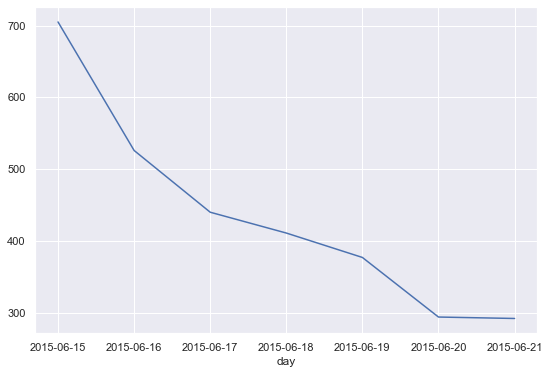

In [128]:
events_data.groupby('day').user_id.nunique()[:n].plot()

Посмотрим на распределение количества удачно решенных степов

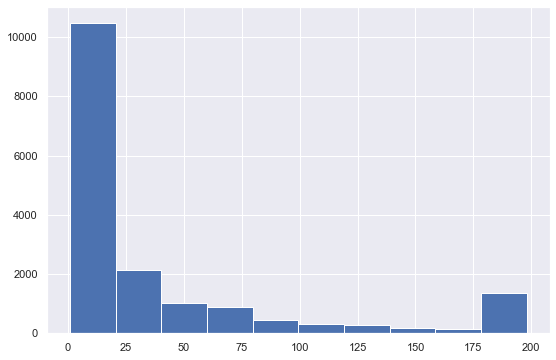

In [129]:
events_data[events_data.action == 'passed'] \
.groupby('user_id', as_index=False).agg({'action' : 'count'}) \
.rename(columns={'action' : 'passed_steps'}).passed_steps.hist()

Для каждого пользователя посчитаем число удачно пройденных степов

In [130]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                        fill_value=0).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Сохраним эти данные в отдельный датасет

In [131]:
users_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                        fill_value=0).reset_index()

users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Теперь у нас есть симпатичная таблица юзеров с статистикой по степам

Установим пороговое значения баллов для получения сертификата

In [132]:
sertificate_value = 170

Укажем для каждого юзера, получил ли он сертификат и сохраним эти данные

In [133]:
check_values = []
for user in users_events_data.passed:
    if user >= sertificate_value:
        check_values.append(True)
    else:
        check_values.append(False)

users_events_data['passed_course'] = check_values

users_events_data.passed_course.value_counts()

False    17801
True      1433
Name: passed_course, dtype: int64

**Лишь 1433 человека из 19234 пытавшихся получили сертификаты и прошли курс до конца**

Приступим к обработке данных о решении юзерами задач курса

Помимо знакомых нам фичей добавилась метка submission_status, показывающая правильно ли (correct) или нет (wrong) пользователь попытался решить задачу данного степа

In [134]:
submissions_data = pd.read_csv('submissions_data_train.csv')

submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [135]:
# аналогично подработаем время

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Для каждого юзера посчитаем число верных и проваленных сабмитов и сохраним эти данные в новый датасет

In [136]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                            fill_value=0).reset_index()

users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Какую паузу в прохождении курса можно считать за слив пользователя?

Соберем информацию о перерывах юзеров при прохождении курса

In [137]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 3600)

gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

Посмотрим на распределение перерывов юзеров в процессе прохождения курса

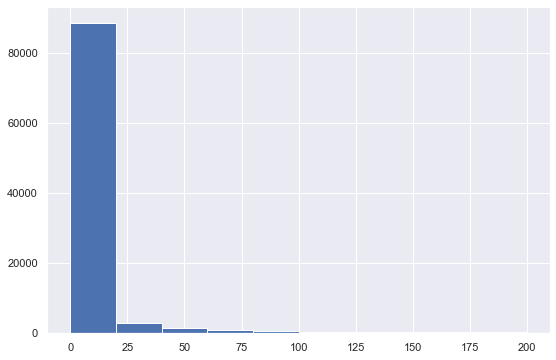

In [138]:
gap_data[gap_data < 200].hist()

**Начинаем анализировать, слился ли юзер с курса**

Найдем и сохраним дату последнего посещения курса для каждого пользователя:

"user_id" - идентификатор пользователя

"last_timestamp" - время последнего посещения курса

In [139]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp' : 'max'}).rename(columns={'timestamp' : 'last_timestamp'})

users_data.tail()

,user_id,last_timestamp
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096
19233,26798,1520978742


Введем необходимые переменные:
    
    now - время последнего появления 
    drop_out_threshold - "порог слива". Например, 30 дней

In [140]:
now = 1520978742
drop_out_threshold = 30*24*3600

Если отсутствовал более 30 дней, считаем, что он юзер слился с курса.

Вычислим и сохраним эту ифнормацию

In [141]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,False
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,False


Объединим данные о пользователях воедино

In [142]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,False,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,False,0.0,0.0


In [143]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,False
1,2,1519226966,False,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,False
4,7,1521634660,False,0.0,0.0,1,1,0,1,False


Посчитаем, сколько дней каждый из пользователей провел на курсе

In [144]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Добавим данные в исходный датафрейм

In [145]:
users_data = users_data.merge(users_days, on='user_id', how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1
1,2,1519226966,False,2.0,0.0,9,9,2,10,False,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2
4,7,1521634660,False,0.0,0.0,1,1,0,1,False,1


**В среднем для получения сертификата необходимо около 25 дней**

In [146]:
round(users_data[users_data.diploma==1].day.mean())

AttributeError: 'DataFrame' object has no attribute 'diploma'

Cохраним данные о первом появлении каждого юзера на курсе

In [147]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp' : 'min'}) \
                .rename({'timestamp' : 'min_timestamp'}, axis=1)

Добавим в общий датафрейм

In [148]:
users_data = users_data.merge(user_min_time, how='outer')

Переименуем колонку и получении диплома

In [149]:
users_data = users_data.rename({'diploma' : 'passed_course'}, axis=1)

Взглянем на собранные данные

In [150]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course,day,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1,1472827464
1,2,1519226966,False,2.0,0.0,9,9,2,10,False,2,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2,1466156809
4,7,1521634660,False,0.0,0.0,1,1,0,1,False,1,1521634660


Ключевая задача - попытаться выяснить, уйдет ли пользователь с курса за первые несколько дней.

Попробуем сделать это на основании поведения в первые три дня. Соответственно, отберем данные за первые 3 дня. Это можно сделать по-разному, и пошел я достаточно не самым стандарным методом

Введем в данные новую фичу "user_time" которая будет хранить в себе значения идентификатора юзера и времени какого-либо его действия

In [151]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [152]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


Пороговое время для трех дней

In [153]:
learning_time_threshold = 3 * 24 * 60 * 60

In [154]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [155]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

Установим пороговое значение времени для каждого юзера

In [156]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


Объединим данные

In [157]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

Проверим, все ли в порядке с разномерностью данных, чтобы ничего не потерять

In [158]:
events_data.shape

(3480703, 8)

Взглянем на предварительно обработанные данные

In [159]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


**Наконец-то, отберем и сохраним данные о первых 3-х днях**

In [160]:
events_data_train = events_data[events_data['user_time'] <= events_data['user_learning_time_threshold']]

Конечно же, взглянем на них

In [161]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Посмотрим на максимально число дней, которое юзер провел на курсе.

В отобранных нами данных это значение не должно превышать трех дней (казалось бы)

In [162]:
events_data_train.groupby('user_id').day.nunique().max()


4

Логично, ведь пользователь мог начать курс, скажем, 15 числа определенного месяца в обед, начит, в нашу таблицу могли попасть и данные о его действиях 16, 17 и 18 числах того же месяца. С 15 по 18 число включительно - 4 дня

Аналогично проведем отбор данных за первые три дня из датафрейма о попытках решения задач

In [163]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

**И снова всё подчиняется логике**

Теперь у нас есть данные за первые три дня, на основании которых мы в дальнейшем попробуем обучить несколько моделей машинного обучения!

Заведем датафрейм для обучения и постепенно будем заполнять его интересными и важными данными

In [164]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename({'day' : 'days'}, axis=1)

Добавили пользователя и число его активных дней за первые 3 дня курса

In [165]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


Добавим туда же число степов, которые пытались пройти юзеры. Заведем новый датафрейм для этого

In [166]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
            .rename({'step_id' : 'steps_tried'}, axis=1)

In [167]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


Объединим его с исходным

In [168]:
X = X.merge(steps_tried, how='outer')

Посмотрим на его размерность, чтобы в дальнейшем сверяться, что мы не теряем данные

In [169]:
X.shape

(8913, 3)

Сохраним число верных субмитов для каждого юзера за первые 3 дня курса

In [170]:
submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                            fill_value=0).reset_index()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27
...,...,...,...
8908,26787,3,0
8909,26790,1,0
8910,26794,31,9
8911,26797,2,0


Объединим все это дело

In [171]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                            fill_value=0).reset_index())

In [172]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Добавим переменную "correct_ration" - процент верно решенных задач за первые 3 дня курса

In [173]:
X['correct_ration'] = X['correct'] / (X['correct'] + X['wrong'])

In [174]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Посчитаем число просмотренных степов для каждого пользователя

In [175]:
X = X.merge(events_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                            fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

Взглянем на промежуточные данные

In [176]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


Контролируем, не произошло ли потери данных

In [177]:
X.shape

(19234, 7)

Заполним пустые ячейки нулями (например, у пользователя не было попыток решения в первые 3 дня)

In [178]:
X = X.fillna(0)

In [179]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course,day,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1,1472827464
1,2,1519226966,False,2.0,0.0,9,9,2,10,False,2,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2,1466156809
4,7,1521634660,False,0.0,0.0,1,1,0,1,False,1,1521634660


Временно расширим датафрейм X

In [180]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

Взглянем на данные

In [181]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,False
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Для обучения моделей выбросим "непонятных" юзеров, которые еще не прошли курс, но и не бросили его.

Оставим тех, кто либо уже прошел курс, либо уже бросил его

In [182]:
X = X[(X.is_gone_user)|(X.passed_course)]

Взглянем на даные

In [183]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed,passed_course,is_gone_user
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
5,17,1.0,1.0,0.0,2.0,0.00,13,False,True


In [184]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            14713
True           False             374
               True             1059
Name: user_id, dtype: int64

**14713** пользователей ушли с курса

**1059** уже прошли его и "вышли" с курса

**374** человек уже прошли его, но почему-то еще не ушли с курса (вероятно, они сделали это совсем недавно)

Также сохраним вектор с целевой переменной, ушел ли юзер с курса, для обучения моделей

In [185]:
y = X.passed_course.map(int)

Уберем лишние колонки и изменим индекс в датафрейме с фичами о юзерах

In [186]:
# уберем линшие колонки

X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [187]:
# уберем user_id в индекс

X = X.set_index('user_id')

Проверим, совпадают ли размерности 

In [188]:
X.shape

(16146, 6)

In [189]:
y.shape

(16146,)

# Приступим к обучению моделей

**Для начала обучим простейшую логистическую регрессию**

In [190]:
from sklearn.linear_model import LogisticRegression

In [191]:
from sklearn.model_selection import train_test_split

In [192]:
linear_logictic_model = LogisticRegression()

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [194]:
linear_logictic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [195]:
coeffs = linear_logictic_model.coef_[0]
intercept = linear_logictic_model.intercept_
features = list(X_train)

In [196]:
print('Фичи и их веса в логичтической регрессии')
print('\n')
for feature, weight in zip(features, coeffs):
    print(f'{feature} - {round(weight, 2)}')

Фичи и их веса в логичтической регрессии


days - 0.6
steps_tried - -0.0
correct - 0.07
wrong - 0.0
correct_ration - 0.92
viewed - -0.0


**Промежуточный итог:**

Больше других на вероятность успешного прохождения курса юзером влияют:
1. Число дней, проведенных на курсе со старта
2. Процент верно решенных задач

Остальные фичи имеют небольшой положительный вес, однако, число опробованных степов на старте немного уменьшает вероятность прохождения курса данным учеником

**Метрики логистической регрессии**

In [197]:
from sklearn.metrics import accuracy_score

In [198]:
from sklearn.metrics import recall_score, precision_score

In [199]:
from sklearn.metrics import roc_auc_score

In [200]:
from sklearn.model_selection import cross_val_score

In [201]:
model_predictions = linear_logictic_model.predict(X_test)

In [202]:
accuracy = accuracy_score(y_test, model_predictions)

accuracy score - неустойчивая к несбалансированным выборкам метрика, показывающая лишь процент верных ответов модели. 

В нашем случае, число юзеров, не дошедших до конца, намного больше, нежели тех, кто его прошел, так что обольщаться такому высокому показателю не стоит

In [203]:
cv_score = cross_val_score(linear_logictic_model, X_test, y_test, cv=12).mean()

**Результат кросс-валидации стоит оценивать аналогично accuracy score**

In [204]:
recall, precision = recall_score(y_test, model_predictions), precision_score(y_test, model_predictions)

**Считая f-меру, будем отдавать приоритет полноте**

*Примером помощи пользвателю в прохождении курса может быть наличие дополнительных попыток для решения задач, милая мотивация типа фотографии котиков после удачного решения степа. 
Совсем нестрашно вывести пару лишних фотографий котиков, если мы ошиблись, и у юзера все получается и без нас.
Однако в нашей задаче нежелательно пропустить того, кто действительно нуждается в поддержке.
В нашей задаче полнота куда важнее точности*

In [205]:
f_score = 4*precision*recall/(recall + 2*precision)

**Неплохой показатель precision, однако, очень слабые recall и f score**

**Возможно, стоит немного иначе распределить веса этим велеичинам при подсчете f score**

In [206]:
roc_auc= roc_auc_score(y_test, model_predictions)

**Весьма нейтральный roc auc score, однако, все же ближе к негативной оценке модели**

**Сохраним значения**

In [207]:
regression_grades = {'precision' : precision, 
                    'recall' : recall,
                    'accuracy' : accuracy,
                    'roc_auc' : roc_auc,
                    'mean_cv' : cv_score, 
                    'f_score' : f_score,
                    'roc_auc' : roc_auc}

In [208]:
for grade, value in regression_grades.items():
    print(f'{grade} - {round(value, 2)}')

precision - 0.58
recall - 0.19
accuracy - 0.92
roc_auc - 0.59
mean_cv - 0.92
f_score - 0.32


# Вывод о работе логистической регрессии

**Модель показала хорошие результаты на перекрестной проверке, однако, дала слабый результат в важном для нас компоненте полноты. 
Стоит попробовать поработать с другими видами моделей**

.

# Обучим дерево решений

**Одиночные деревья решений - весьма слабые модели, склонные к переобучению, однако, хочется посмотреть на логику их решений**

In [209]:
from sklearn.tree import DecisionTreeClassifier

In [210]:
from sklearn import tree

In [211]:
from sklearn.model_selection import GridSearchCV

**В целях эксперимента сначала дадим дереву переобучиться**

In [212]:
my_tree = DecisionTreeClassifier()

In [213]:
my_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [214]:
first_predictions = my_tree.predict(X_test)

*Посчитаем процент верных ответов*

In [215]:
accuracy = accuracy_score(first_predictions, y_test)

In [216]:
accuracy

0.8944272445820434

*Обратим внимание, что метрика "accuracy" необъективна в несбалансированных выборках.
Так как число юзеров, закончивших курс, намного меньше бросивших его, в нашем метрика "accuracy" не несет особой важности.*

In [217]:
mean_cv = cross_val_score(my_tree, X_test, y_test, cv=5).mean()

In [218]:
mean_cv

0.8919504643962849

Мы получили весьма солидное среднее значение на перекрестной проверке, однако, далее мы убедимся, что его возможно улучшить

Посчитаем более важные для нас параметры "recall" и "f_score"

In [219]:
recall = recall_score(first_predictions, y_test)

In [220]:
recall

0.35148514851485146

In [221]:
precision = precision_score(first_predictions, y_test)

In [222]:
precision

0.2526690391459075

In [223]:
f_score = 4*recall*precision/(recall + 2*precision)

In [224]:
f_score

0.41459854014598535

**Вывод о переобученном дереве**

Алгоритм показал относительно неплохие "accuracy" и "cross_val" метрики, однако, продемонстрировал слабый результат в более важном для нас показателе полноты 

**Теперь найдем оптимальное дерево решений**

In [225]:
parameters = {'max_depth' : range(3, 20)}

In [226]:
grid_model = GridSearchCV(my_tree, parameters, cv=5)

In [227]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(3, 20)}, pre_dispatch='2*n_jobs',


In [228]:
grid_model.best_params_

{'max_depth': 3}

**Лучшая глубина - 3**

In [229]:
parameters = {'min_samples_split' : range(10, 60, 5),
             'min_samples_leaf' : range(10, 100, 10),
             'max_depth' : [3],
             'criterion' : ['entropy']}

In [230]:
grid_model = GridSearchCV(my_tree, parameters, cv=5)

In [231]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy'], 'max_depth': [3],
         

In [232]:
grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

**Некоторые дополнительные подходящие критерии**

**Возьмем лучшее дерево и визуализируем его**

In [233]:
best_tree = grid_model.best_estimator_

[Text(251.10000000000002, 285.39000000000004, 'X[2] <= 7.5\nentropy = 0.434\nsamples = 12916\nvalue = [11764, 1152]'),
 Text(125.55000000000001, 203.85000000000002, 'X[2] <= 1.5\nentropy = 0.229\nsamples = 10551\nvalue = [10160, 391]'),
 Text(62.775000000000006, 122.31, 'X[5] <= 1.5\nentropy = 0.138\nsamples = 7566\nvalue = [7419, 147]'),
 Text(31.387500000000003, 40.76999999999998, 'entropy = 0.094\nsamples = 3885\nvalue = [3838, 47]'),
 Text(94.16250000000001, 40.76999999999998, 'entropy = 0.18\nsamples = 3681\nvalue = [3581, 100]'),
 Text(188.32500000000002, 122.31, 'X[0] <= 1.5\nentropy = 0.408\nsamples = 2985\nvalue = [2741, 244]'),
 Text(156.9375, 40.76999999999998, 'entropy = 0.378\nsamples = 2651\nvalue = [2457, 194]'),
 Text(219.71250000000003, 40.76999999999998, 'entropy = 0.609\nsamples = 334\nvalue = [284, 50]'),
 Text(376.65000000000003, 203.85000000000002, 'X[2] <= 15.5\nentropy = 0.906\nsamples = 2365\nvalue = [1604, 761]'),
 Text(313.875, 122.31, 'X[2] <= 10.5\nentropy 

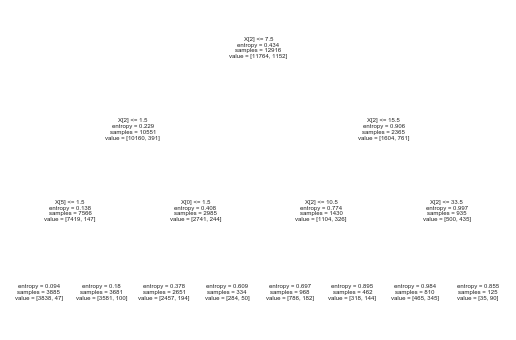

In [234]:
tree.plot_tree(best_tree.fit(X_train, y_train))

**Ключевой вклад в работу алгоритма вносят фичи "steps_tried" и "correct_rating",
Означающие соответственно количество опробованных степов и процент удачных сабмитов**

.

**Посчитаем и сохраним основные метрики**

In [235]:
first_predictions = best_tree.predict(X_test)

In [236]:
accuracy = accuracy_score(first_predictions, y_test)

In [237]:
mean_cv = cross_val_score(my_tree, X_test, y_test, cv=5).mean()

In [238]:
recall = recall_score(first_predictions, y_test)

precisions = precision_score(first_predictions, y_test)

*Посчитаем f-меру, отдав приоритет полноте*

In [239]:
f_score = 4*recall*precision / (recall + 2*precision)

In [240]:
roc_auc = roc_auc_score(first_predictions, y_test)

In [241]:
tree_grades = {'accuracy' : accuracy, 
              'mean_cv' : mean_cv, 
              'recall' : recall,
              'precision' : precision,
              'f_score' : f_score,
              'roc_auc' : roc_auc}

In [242]:
for name, grade in tree_grades.items():
    print(f'{name} - {round(grade, 2)}')

accuracy - 0.92
mean_cv - 0.89
recall - 0.58
precision - 0.25
f_score - 0.54
roc_auc - 0.75


# Вывод о работе дерева решений

**Алгоритм показал более достойные показатели, нежели логистическая регрессия.
Однако воспользовавшись бустингом деревьев мы можем создать более комплексную и сильную модель - случайный лес решений**

.

# Обучим лес

In [243]:
from sklearn.ensemble import RandomForestClassifier

In [244]:
from sklearn.model_selection import GridSearchCV

In [245]:
random_forest = RandomForestClassifier()

**Выясним подходящее число деревьев в лесу**

In [246]:
params = {'n_estimators' : range(10, 110, 5)}

In [247]:
grid_search = GridSearchCV(random_forest, params, cv=5)

In [248]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [249]:
grid_search.best_params_

{'n_estimators': 65}

*Лучший вариант - 55*

In [250]:
random_forest = RandomForestClassifier(n_estimators=55)

In [251]:
params = {'max_depth' : range(1, 20)}

In [252]:
grid_search = GridSearchCV(random_forest, params, cv=5)

In [253]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=55, n_jobs=None,
                                              oob_score=False,
                                              random

In [254]:
grid_search.best_params_

{'max_depth': 5}

*Лучшая максимальная глубина - 5*

In [255]:
random_forest = RandomForestClassifier(n_estimators=55, max_depth=5)

In [256]:
params = {'min_samples_split' : range(10, 30, 5), 
          'min_samples_leaf' : range(10, 30, 5),
          'max_leaf_nodes' : range(10, 30, 5)}

In [257]:
grid_search = GridSearchCV(random_forest, params, cv=5)

In [258]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=55, n_jobs=None,
                                              oob_score=False,
                                              random_st

In [259]:
grid_search.best_params_

{'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}

*Получив оптимальные параметры, создадим и протестируем модель, собрав в нее полученные ранее параметры*

In [260]:
best_forest = RandomForestClassifier(n_estimators=55, max_depth=5,
                                    max_leaf_nodes=25, min_samples_leaf=20,
                                    min_samples_split=10, criterion='entropy')

In [261]:
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=25, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Посчитаем и соберем вместе нужные метрики

In [262]:
forest_grades = {}

In [263]:
mean_cv = cross_val_score(best_forest, X_test, y_test, cv=5).mean()

In [264]:
forest_grades['mean_cv'] = mean_cv

In [265]:
predictions = best_forest.predict(X_test)

In [266]:
accuracy = accuracy_score(predictions, y_test)

In [267]:
forest_grades['accuracy'] = accuracy

In [268]:
recall = recall_score(first_predictions, y_test)

precisions = precision_score(first_predictions, y_test)

In [269]:
forest_grades['recall'] = recall
forest_grades['precision'] = precision

*Посчитаем f-меру, отдав приоритет полноте*

In [270]:
f_score = 4*recall*precision / (recall + 2*precision)

In [271]:
forest_grades['f_score'] = f_score

In [272]:
roc_auc = roc_auc_score(predictions, y_test)

In [273]:
forest_grades['roc_auc'] = roc_auc

In [274]:
for grade, value in forest_grades.items():
    print(f'{grade} - {round(value, 2)}')

mean_cv - 0.92
accuracy - 0.92
recall - 0.58
precision - 0.25
f_score - 0.54
roc_auc - 0.75


# Вывод о работе леса

**Алгоритм показал наиболее удачные метрики полноты, f_score и aoc_auc_score в сравнении с деревом решений и логистической регрессией. 
По структуре лес решений кажется наиболее удачным вариантом из рассмотренных в проекте**

In [ ]:
Описать предобработку данных, предложить варианты воздействия на юзера, посмотреть на важные фичи при отборе юзеров.